In [1]:
!pip install koolbox scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


# Imports and configs

In [2]:
from koolbox import Trainer, WeightedEnsembleRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from scipy.stats import pearsonr as pr
from xgboost import XGBRegressor
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import joblib
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/drw-crypto-market-prediction/train.parquet"
    test_path = "/kaggle/input/drw-crypto-market-prediction/test.parquet"
    sample_sub_path = "/kaggle/input/drw-crypto-market-prediction/sample_submission.csv"

    target = "label"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [5]:
def add_features(df):
    data = df.copy()
    features_df = pd.DataFrame(index=data.index)
    
    features_df['bid_ask_spread_proxy'] = data['ask_qty'] - data['bid_qty']
    features_df['total_liquidity'] = data['bid_qty'] + data['ask_qty']
    features_df['trade_imbalance'] = data['buy_qty'] - data['sell_qty']
    features_df['total_trades'] = data['buy_qty'] + data['sell_qty']
    
    features_df['volume_per_trade'] = data['volume'] / (data['buy_qty'] + data['sell_qty'] + 1e-8)
    features_df['buy_volume_ratio'] = data['buy_qty'] / (data['volume'] + 1e-8)
    features_df['sell_volume_ratio'] = data['sell_qty'] / (data['volume'] + 1e-8)
    
    features_df['buying_pressure'] = data['buy_qty'] / (data['buy_qty'] + data['sell_qty'] + 1e-8)
    features_df['selling_pressure'] = data['sell_qty'] / (data['buy_qty'] + data['sell_qty'] + 1e-8)
    
    features_df['order_imbalance'] = (data['bid_qty'] - data['ask_qty']) / (data['bid_qty'] + data['ask_qty'] + 1e-8)
    features_df['order_imbalance_abs'] = np.abs(features_df['order_imbalance'])
    features_df['bid_liquidity_ratio'] = data['bid_qty'] / (data['volume'] + 1e-8)
    features_df['ask_liquidity_ratio'] = data['ask_qty'] / (data['volume'] + 1e-8)
    features_df['depth_imbalance'] = features_df['total_trades'] - data['volume']
    
    features_df['buy_sell_ratio'] = data['buy_qty'] / (data['sell_qty'] + 1e-8)
    features_df['bid_ask_ratio'] = data['bid_qty'] / (data['ask_qty'] + 1e-8)
    features_df['volume_liquidity_ratio'] = data['volume'] / (data['bid_qty'] + data['ask_qty'] + 1e-8)

    features_df['buy_volume_product'] = data['buy_qty'] * data['volume']
    features_df['sell_volume_product'] = data['sell_qty'] * data['volume']
    features_df['bid_ask_product'] = data['bid_qty'] * data['ask_qty']
    
    features_df['market_competition'] = (data['buy_qty'] * data['sell_qty']) / ((data['buy_qty'] + data['sell_qty']) + 1e-8)
    features_df['liquidity_competition'] = (data['bid_qty'] * data['ask_qty']) / ((data['bid_qty'] + data['ask_qty']) + 1e-8)
    
    total_activity = data['buy_qty'] + data['sell_qty'] + data['bid_qty'] + data['ask_qty']
    features_df['market_activity'] = total_activity
    features_df['activity_concentration'] = data['volume'] / (total_activity + 1e-8)
    
    features_df['info_arrival_rate'] = (data['buy_qty'] + data['sell_qty']) / (data['volume'] + 1e-8)
    features_df['market_making_intensity'] = (data['bid_qty'] + data['ask_qty']) / (data['buy_qty'] + data['sell_qty'] + 1e-8)
    features_df['effective_spread_proxy'] = np.abs(data['buy_qty'] - data['sell_qty']) / (data['volume'] + 1e-8)
    
    lambda_decay = 0.95
    ofi = data['buy_qty'] - data['sell_qty']
    features_df['order_flow_imbalance_ewm'] = ofi.ewm(alpha=1-lambda_decay).mean()

    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    
    return features_df

In [6]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test.drop(CFG.target, axis=1)

Reducing memory usage for: train
--- Memory usage before: 3594.93 MB
--- Memory usage after: 961.92 MB
--- Decreased memory usage by 73.2%

Reducing memory usage for: test
--- Memory usage before: 3678.76 MB
--- Memory usage after: 984.36 MB
--- Decreased memory usage by 73.2%



In [7]:
X = pd.concat([add_features(X), X], axis=1)
X_test = pd.concat([add_features(X_test), X_test], axis=1)

In [8]:
features = [
    'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'trade_imbalance', 
    'total_trades', 'volume_per_trade', 'selling_pressure', 'ask_liquidity_ratio',
    'X2', 'X10', 'X11', 'X13', 'X14', 'X18', 'X19', 'X20', 'X26', 'X27', 'X40', 
    'X42', 'X60', 'X63', 'X64', 'X81', 'X82', 'X86', 'X87', 'X88', 'X99', 'X100',
    'X119', 'X120', 'X124', 'X125', 'X135', 'X143', 'X145', 'X157', 'X160', 'X161', 
    'X264', 'X265', 'X267', 'X269', 'X270', 'X289', 'X309', 'X314', 'X320', 'X325',
    'X331', 'X342', 'X480', 'X511', 'X534', 'X579', 'X580', 'X582', 'X602', 'X612',
    'X614', 'X764', 'X782', 'X808', 'X811', 'X863', 'X865', 'X866', 'X868', 'X877'
]

X = X[features]
X_test = X_test[features]

# Training base models

In [9]:
def pearsonr(y_true, y_pred):
    return pr(y_true, y_pred)[0]

In [10]:
lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.2226266674551101,
    "learning_rate": 0.010961464232141296,
    "min_child_samples": 99,
    "min_child_weight": 0.14721736423062415,
    "n_estimators": 1539,
    "n_jobs": -1,
    "num_leaves": 30,
    "random_state": 42,
    "reg_alpha": 84.32633971693426,
    "reg_lambda": 3.792226171108948,
    "subsample": 0.7530807885306681,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.17688585186402928,
    "learning_rate": 0.016709549379582814,
    "min_child_samples": 78,
    "min_child_weight": 0.009491338931754025,
    "n_estimators": 724,
    "n_jobs": -1,
    "num_leaves": 65,
    "random_state": 42,
    "reg_alpha": 27.170232978125895,
    "reg_lambda": 67.71163720508015,
    "subsample": 0.6859603432745125,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.5373129074832186,
    "colsample_bynode": 0.14466876618659996,
    "colsample_bytree": 0.6390396540112111,
    "gamma": 2.9313530267910535,
    "learning_rate": 0.0048328643606231686,
    "max_depth": 10,
    "max_leaves": 31,
    "min_child_weight": 96,
    "n_estimators": 1354,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 60.74236045282153,
    "reg_lambda": 81.62573511547255,
    "subsample": 0.12403674749602688,
    "verbosity": 0
}

In [11]:
fold_scores = {}
overall_scores = {}

oof_preds = {}
test_preds = {}

## LightGBM (gbdt)

In [12]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

lgbm_trainer.fit(X, y)

fold_scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
overall_scores["LightGBM (gbdt)"] = [pearsonr(lgbm_trainer.oof_preds, y)]
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

--- Fold 0 - pearsonr: 0.176169 - Time: 42.58 s
--- Fold 1 - pearsonr: 0.147518 - Time: 42.78 s
--- Fold 2 - pearsonr: 0.096722 - Time: 42.82 s
--- Fold 3 - pearsonr: 0.183146 - Time: 43.23 s
--- Fold 4 - pearsonr: 0.111217 - Time: 42.73 s

------ Overall pearsonr: 0.133960 - Mean pearsonr: 0.142954 ± 0.034305 - Time: 214.94 s


## LightGBM (goss)

In [13]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

lgbm_goss_trainer.fit(X, y)

fold_scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
overall_scores["LightGBM (goss)"] = [pearsonr(lgbm_goss_trainer.oof_preds, y)]
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

--- Fold 0 - pearsonr: 0.174389 - Time: 32.99 s
--- Fold 1 - pearsonr: 0.151054 - Time: 31.47 s
--- Fold 2 - pearsonr: 0.100643 - Time: 32.00 s
--- Fold 3 - pearsonr: 0.179922 - Time: 31.74 s
--- Fold 4 - pearsonr: 0.104736 - Time: 31.60 s

------ Overall pearsonr: 0.132310 - Mean pearsonr: 0.142149 ± 0.033669 - Time: 160.75 s


## XGBoost

In [14]:
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

xgb_trainer.fit(X, y)

fold_scores["XGBoost"] = xgb_trainer.fold_scores
overall_scores["XGBoost"] = [pearsonr(xgb_trainer.oof_preds, y)]
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

--- Fold 0 - pearsonr: 0.192809 - Time: 76.40 s
--- Fold 1 - pearsonr: 0.171474 - Time: 80.23 s
--- Fold 2 - pearsonr: 0.099456 - Time: 77.06 s
--- Fold 3 - pearsonr: 0.170347 - Time: 80.57 s
--- Fold 4 - pearsonr: 0.092892 - Time: 78.61 s

------ Overall pearsonr: 0.135504 - Mean pearsonr: 0.145395 ± 0.041031 - Time: 393.67 s


# Ensembling

In [15]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [16]:
joblib.dump(X, "oof_preds.pkl")
joblib.dump(X_test, "test_preds.pkl")

['test_preds.pkl']

In [17]:
ensembler = WeightedEnsembleRegressor(
    objective="maximize",
    metric=pearsonr,
    n_trials=1000,
    verbose=True
)

ensembler.fit(X, y)

[I 2025-05-30 23:49:42,662] A new study created in memory with name: no-name-4e078ac3-5913-4414-b7d5-e3db1570c68c
[I 2025-05-30 23:49:42,692] Trial 0 finished with value: 0.1392740507951425 and parameters: {'LightGBM (gbdt)': 0.3745401188473625, 'LightGBM (goss)': 0.9507143064099162, 'XGBoost': 0.7319939418114051}. Best is trial 0 with value: 0.1392740507951425.
[I 2025-05-30 23:49:42,710] Trial 1 finished with value: 0.13733296551122143 and parameters: {'LightGBM (gbdt)': 0.5986584841970366, 'LightGBM (goss)': 0.15601864044243652, 'XGBoost': 0.15599452033620265}. Best is trial 0 with value: 0.1392740507951425.
[I 2025-05-30 23:49:42,728] Trial 2 finished with value: 0.13868135839436652 and parameters: {'LightGBM (gbdt)': 0.05808361216819946, 'LightGBM (goss)': 0.8661761457749352, 'XGBoost': 0.6011150117432088}. Best is trial 0 with value: 0.1392740507951425.
[I 2025-05-30 23:49:42,745] Trial 3 finished with value: 0.14092080853872094 and parameters: {'LightGBM (gbdt)': 0.7080725777960

WeightedEnsembleRegressor(metric=<function pearsonr at 0x7c6c93d599e0>,
                          n_trials=1000, objective='maximize', verbose=True)

In [18]:
fold_scores["Weighted Ensemble"] = [pearsonr(ensembler.predict(X), y)] * CFG.n_folds
overall_scores["Weighted Ensemble"] = [pearsonr(ensembler.predict(X), y)]
ensemble_test_preds = ensembler.predict(X_test)

# Submission

In [19]:
sub = pd.read_csv(CFG.sample_sub_path)
sub["prediction"] = ensemble_test_preds
sub.to_csv(f"sub_ensemble_{overall_scores['Weighted Ensemble'][0]:.6f}.csv", index=False)
sub.head()

,ID,prediction
0,1,0.076458
1,2,0.023326
2,3,0.062692
3,4,-0.166491
4,5,0.124003


# Results

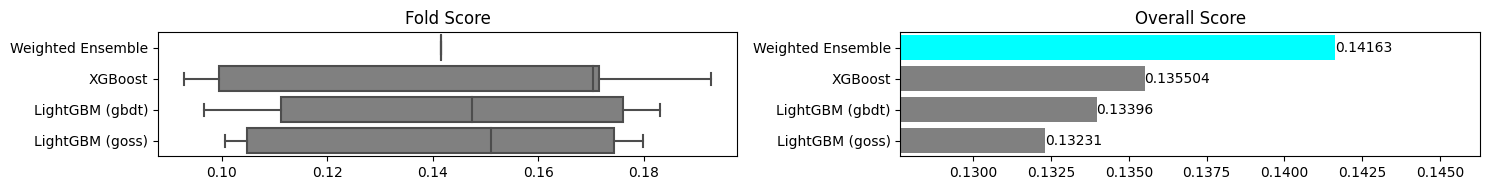

In [20]:
fold_scores = pd.DataFrame(fold_scores)
overall_scores = pd.DataFrame(overall_scores).transpose().sort_values(by=0, ascending=False)
order = overall_scores.index.tolist()

min_score = overall_scores.values.flatten().min()
max_score = overall_scores.values.flatten().max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, fold_scores.shape[1] * 0.5))

boxplot = sns.boxplot(data=fold_scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold Score")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores.values.flatten(), y=overall_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Overall Score")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(overall_scores.values.flatten(), overall_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()